In [8]:
#pip install openmeteo-requests requests-cache retry-requests

In [9]:
# pip install geopandas

### Fetch Current and Daily Weather Forecast from Open-Meteo API

In [7]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import os

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# List of coordinates (latitude and longitude) for each MA county
ma_counties_coordinates = [
    {"county_name": "Barnstable", "latitude": 41.7003, "longitude": -70.3002},
    {"county_name": "Berkshire", "latitude": 42.3118, "longitude": -73.1822},
    {"county_name": "Bristol", "latitude": 41.7938, "longitude": -71.1350},
    {"county_name": "Dukes", "latitude": 41.4033, "longitude": -70.6693},
    {"county_name": "Essex", "latitude": 42.6334, "longitude": -70.7829},
    {"county_name": "Franklin", "latitude": 42.5795, "longitude": -72.6151},
    {"county_name": "Hampden", "latitude": 42.1175, "longitude": -72.6009},
    {"county_name": "Hampshire", "latitude": 42.3389, "longitude": -72.6417},
    {"county_name": "Middlesex", "latitude": 42.4672, "longitude": -71.2874},
    {"county_name": "Nantucket", "latitude": 41.2835, "longitude": -70.0995},
    {"county_name": "Norfolk", "latitude": 42.1621, "longitude": -71.1912},
    {"county_name": "Plymouth", "latitude": 41.9880, "longitude": -70.7528},
    {"county_name": "Suffolk", "latitude": 42.3601, "longitude": -71.0589},
    {"county_name": "Worcester", "latitude": 42.4002, "longitude": -71.9065}
]

# Dictionary to store weather data by county
county_weather_data = {}

# Function to fetch and process weather data for a given set of coordinates
def fetch_weather_data(county_name, latitude, longitude):
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
	    "current": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "weather_code", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"],
	    "daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "sunrise", "sunset", "uv_index_max", "precipitation_probability_max", "wind_speed_10m_max", "wind_gusts_10m_max"],
        "timezone": "America/New_York",
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch",
        "forecast_days": 7
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process the response for the given coordinates
    response = responses[0]

    # Process current data
    current = response.Current()
    current_temperature_2m = current.Variables(0).Value()
    current_relative_humidity_2m = current.Variables(1).Value()
    current_apparent_temperature = current.Variables(2).Value()
    current_precipitation = current.Variables(3).Value()
    current_weather_code = current.Variables(4).Value()
    current_wind_speed_10m = current.Variables(5).Value()
    current_wind_direction_10m = current.Variables(6).Value()
    current_wind_gusts_10m = current.Variables(7).Value()

    # Prepare current weather data for DataFrame
    current_data = {
        "time": [pd.to_datetime(current.Time(), unit="s", utc=True)],
        "temperature_2m": [current_temperature_2m],
        "relative_humidity_2m": [current_relative_humidity_2m],
        "apparent_temperature": [current_apparent_temperature],
        "precipitation": [current_precipitation],
        "weather_code": [current_weather_code],
        "wind_speed_10m": [current_wind_speed_10m],
        "wind_direction_10m": [current_wind_direction_10m],
        "wind_gusts_10m": [current_wind_gusts_10m],
    }

    # Create a DataFrame from the current weather data
    current_df = pd.DataFrame(data=current_data)

    # Process daily data
    daily = response.Daily()
    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left"
        ),
        "county": county_name,
        "latitude": latitude,
        "longitude": longitude,
        "weather_code": daily.Variables(0).ValuesAsNumpy(),
        "temperature_2m_max": daily.Variables(1).ValuesAsNumpy(),
        "temperature_2m_min": daily.Variables(2).ValuesAsNumpy(),
        "sunrise": daily.Variables(3).ValuesAsNumpy(),
        "sunset": daily.Variables(4).ValuesAsNumpy(),
        "uv_index_max": daily.Variables(5).ValuesAsNumpy(),
        "precipitation_probability_max": daily.Variables(6).ValuesAsNumpy(),
        "wind_speed_10m_max": daily.Variables(7).ValuesAsNumpy(),
        "wind_gusts_10m_max": daily.Variables(8).ValuesAsNumpy()
    }
    daily_df = pd.DataFrame(daily_data)

    # Store DataFrames in the dictionary by county
    county_weather_data[county_name] = {
        "current": current_df,
        "daily": daily_df
    }
    print(f"Processed weather data for {county_name}")

# Loop through each set of coordinates and fetch weather data
for county in ma_counties_coordinates:
    fetch_weather_data(county["county_name"], county["latitude"], county["longitude"])

Processed weather data for Barnstable
Processed weather data for Berkshire
Processed weather data for Bristol
Processed weather data for Dukes
Processed weather data for Essex
Processed weather data for Franklin
Processed weather data for Hampden
Processed weather data for Hampshire
Processed weather data for Middlesex
Processed weather data for Nantucket
Processed weather data for Norfolk
Processed weather data for Plymouth
Processed weather data for Suffolk
Processed weather data for Worcester


### Chloropeth Map for Current Weather Features

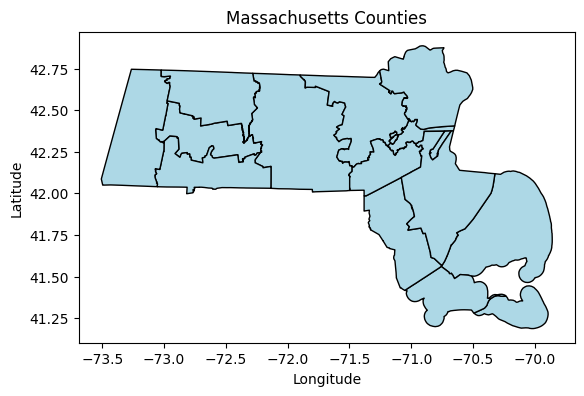

In [5]:
import pandas as pd
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the CSV file into a Pandas DataFrame
ma_counties_boundaries = pd.read_csv('../DS5110-Final-Project/dataset/cleaned_data/ma_counties_boundarie.csv')

# Convert the 'geometry' column from WKT format to Shapely geometry objects
ma_counties_boundaries['geometry'] = ma_counties_boundaries['geometry'].apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame
ma_counties_gdf = gpd.GeoDataFrame(ma_counties_boundaries, geometry='geometry')

# Set the coordinate reference system (CRS)
ma_counties_gdf.set_crs(epsg=4326, inplace=True)

# Plot the GeoDataFrame with the county boundaries
ma_counties_gdf.plot(edgecolor='black', facecolor='lightblue')
plt.title("Massachusetts Counties")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [8]:
import folium
import random

# Create a base Folium map centered around Massachusetts
m = folium.Map(location=[42.4072, -71.3824], zoom_start=7, tiles="cartodbpositron")

# Create a function to generate random colors for each county
def random_color():
    return f'#{random.randint(0, 255):02x}{random.randint(0, 255):02x}{random.randint(0, 255):02x}'

# Add counties as a GeoJSON layer with unique colors and tooltips
for _, row in ma_counties_gdf.iterrows():
    county_name = row['NAME']
    weather_info = county_weather_data[county_name]["current"]
    
    popup_text = (
    f"Temperature: {round(weather_info['temperature_2m'].values[0])} °F<br>"
    f"Humidity: {weather_info['relative_humidity_2m'].values[0]} %<br>"
    f"Precipitation: {weather_info['precipitation'].values[0]} in<br>"
    f"Wind Speed: {round(weather_info['wind_speed_10m'].values[0], 2)} mph<br>"
    f"Wind Direction: {round(weather_info['wind_direction_10m'].values[0], 2)} °<br>"
    f"Wind Gusts: {round(weather_info['wind_gusts_10m'].values[0], 2)} mph"
)

    
    folium.GeoJson(
        row['geometry'],
        style_function=lambda feature, color=random_color(): {
            'fillColor': color,
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.6,
        },
        tooltip=folium.Tooltip(county_name),
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# Display the map
m

In [ ]:
output_dir = 'visualizations'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'current_chloropeth_map.html')
m.save(output_file)


### Generate Heatmap for Daily Features by Counties

In [11]:
# Function to plot a heatmap for a given feature
def plot_heatmap(feature):
    # Create a dataframe for the selected feature
    feature_data = pd.DataFrame()
    for county, weather_data in county_weather_data.items():
        daily_data = weather_data["daily"]
        feature_data[county] = daily_data[feature]

    # Convert the index values to actual dates
    feature_data.index = daily_data["date"].dt.date

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    heatmap = sns.heatmap(feature_data.transpose(), cmap="coolwarm", annot=True, fmt=".1f", cbar=True)

    # Customizing the color bar
    color_bar = heatmap.collections[0].colorbar
    if feature == "temperature_2m_max" or feature == "temperature_2m_min":
        color_bar.set_label('Temperature (°F)', rotation=270, labelpad=20)
    elif feature == "precipitation_probability_max":
        color_bar.set_label('Precipitation Probability (%)', rotation=270, labelpad=20)
    elif feature == "wind_speed_10m_max" or feature == "wind_gusts_10m_max":
        color_bar.set_label('Wind Speed (mph)', rotation=270, labelpad=20)
    else:
        color_bar.set_label(feature, rotation=270, labelpad=20)

    plt.title(f"7-Day {feature.replace('_', ' ').title()} Forecast by County", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("County", fontsize=12)
    plt.xticks(rotation=45)

    # Save the heatmap as a PNG file in the visualizations directory
    plt.savefig(f'visualizations/{feature}_heatmap.png')

    # Display the heatmap
    plt.show()


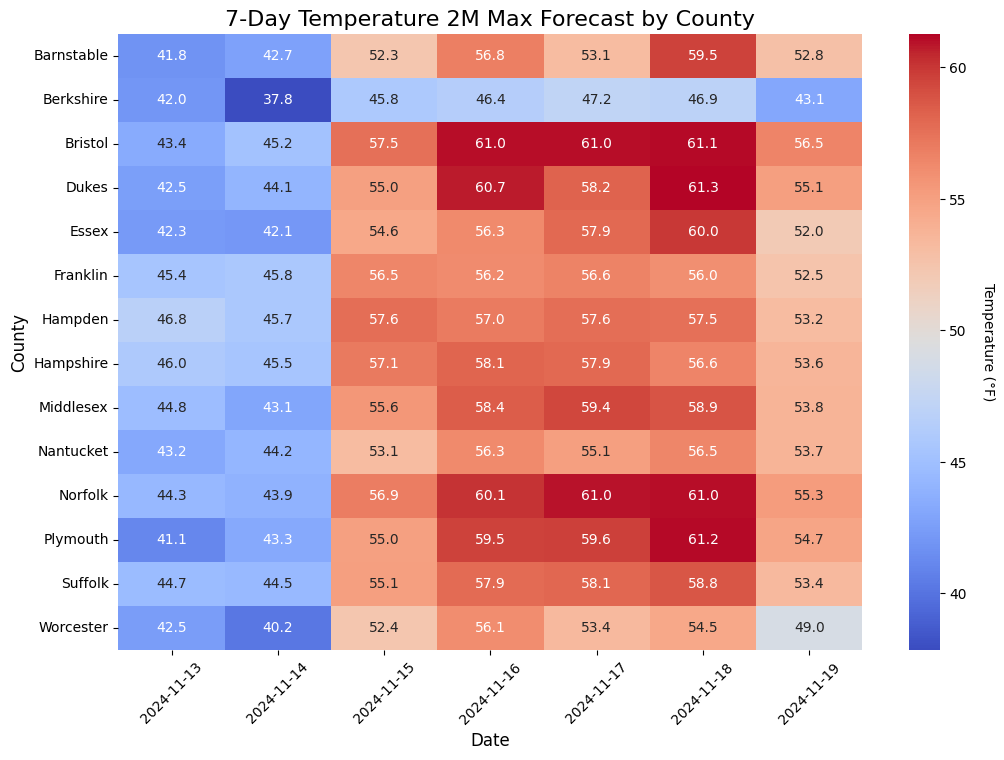

In [12]:
plot_heatmap("temperature_2m_max")

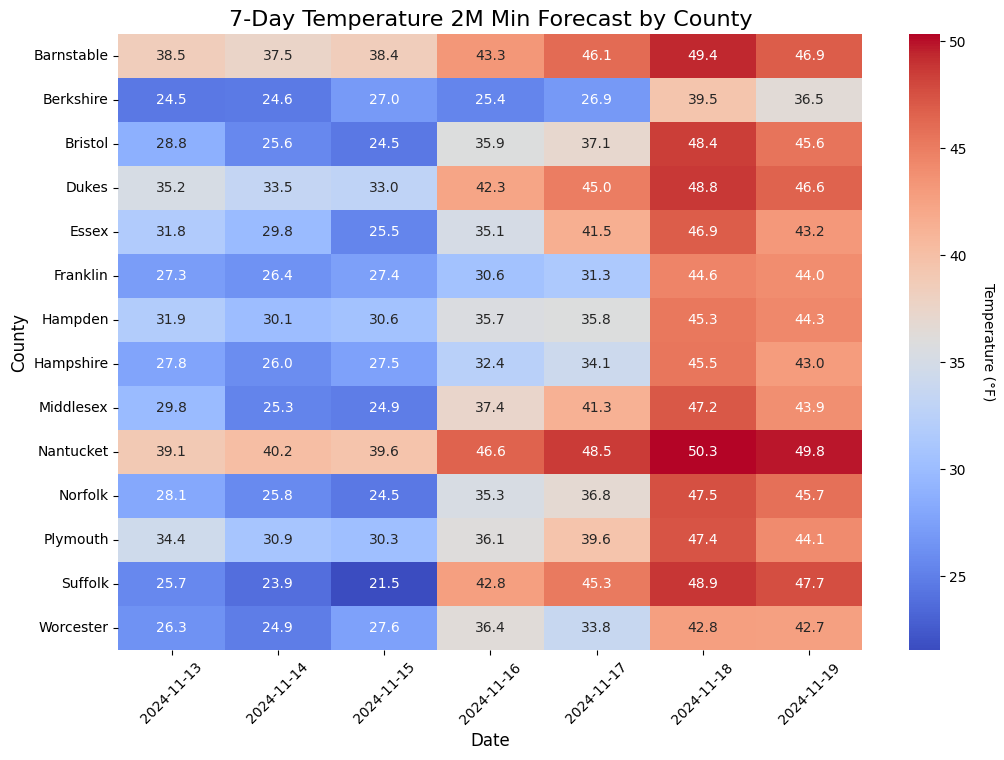

In [13]:
plot_heatmap("temperature_2m_min")

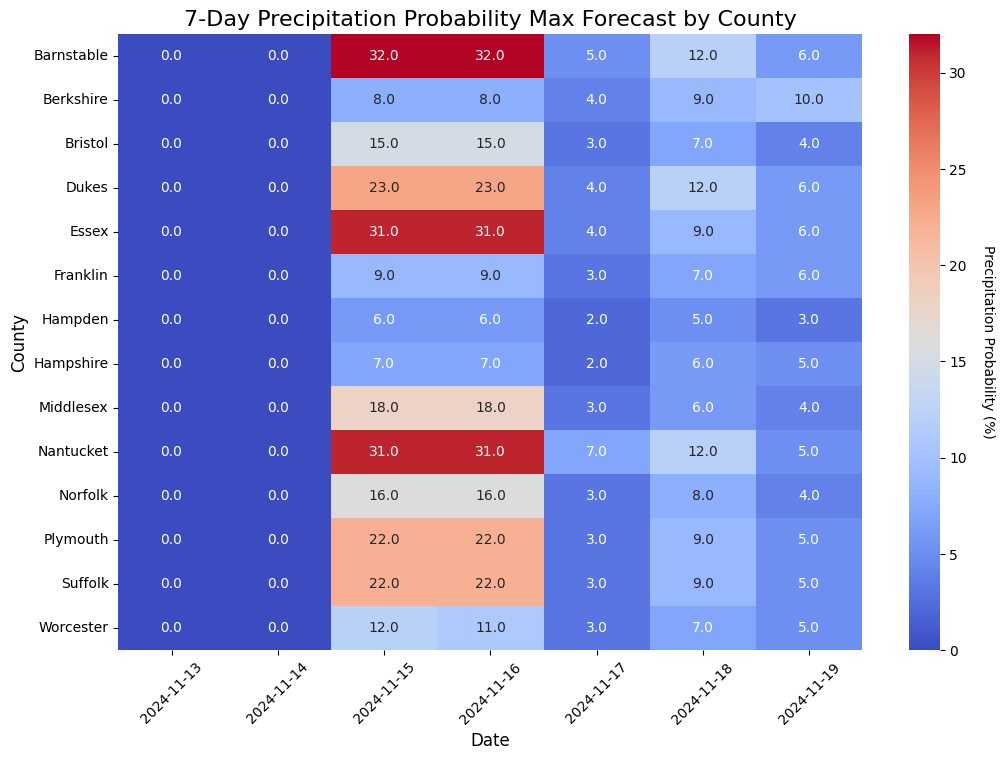

In [14]:
plot_heatmap("precipitation_probability_max")

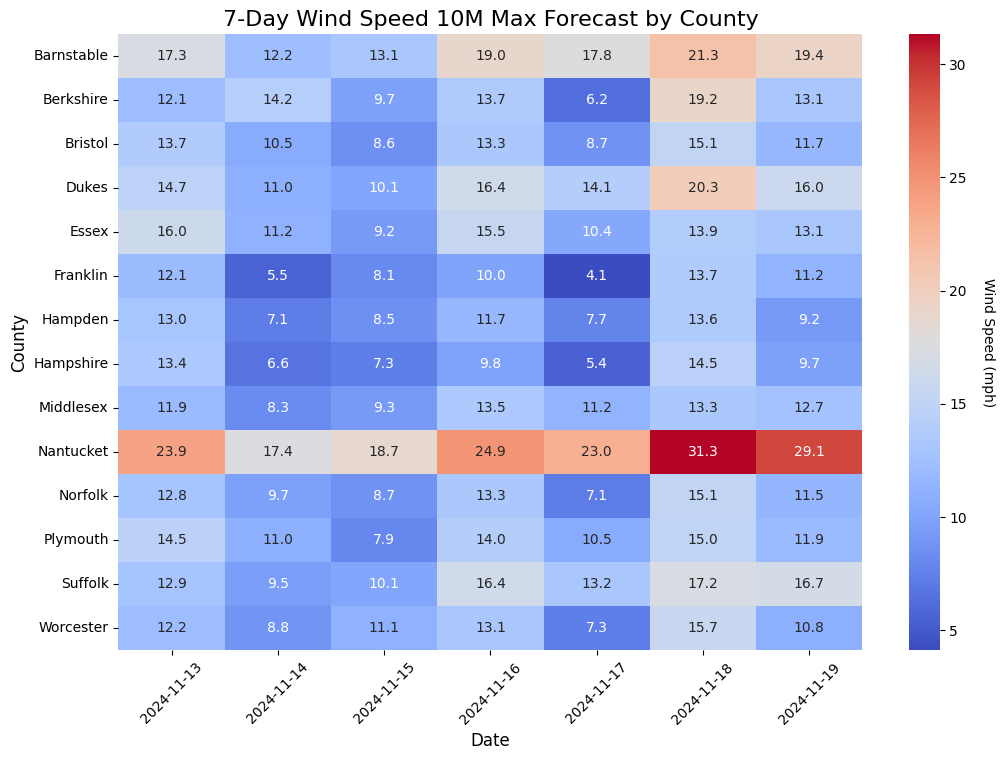

In [15]:
plot_heatmap("wind_speed_10m_max")

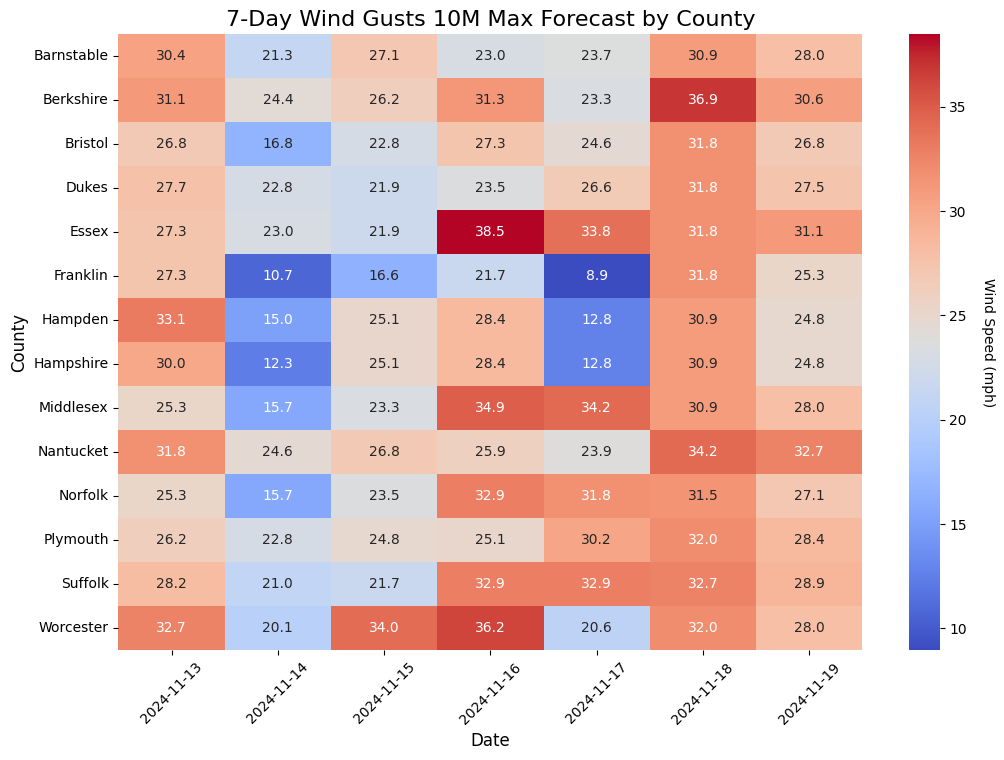

In [16]:
plot_heatmap("wind_gusts_10m_max")

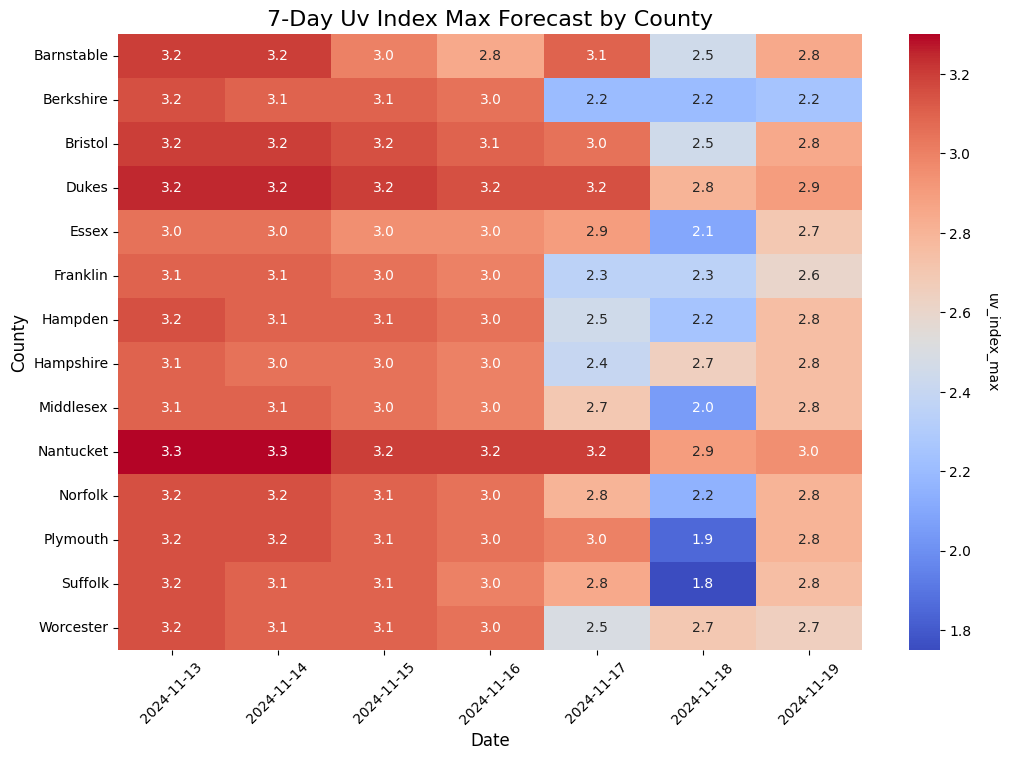

In [17]:
plot_heatmap("uv_index_max")

### Current Weather Conditions By MA County

In [18]:
for county, weather_data in county_weather_data.items():
    current_weather = weather_data["current"]
    print(f"County: {county}")
    for feature, value in current_weather.items():
        print(f"{feature}: {value.values[0]}")
    print()


County: Barnstable
time: 2024-11-13T19:30:00.000000000
temperature_2m: 40.66699981689453
relative_humidity_2m: 57.0
apparent_temperature: 29.473325729370117
precipitation: 0.0
weather_code: 1.0
wind_speed_10m: 15.659000396728516
wind_direction_10m: 360.0
wind_gusts_10m: 25.501798629760742

County: Berkshire
time: 2024-11-13T19:30:00.000000000
temperature_2m: 42.073699951171875
relative_humidity_2m: 26.0
apparent_temperature: 33.69075012207031
precipitation: 0.0
weather_code: 0.0
wind_speed_10m: 5.236682891845703
wind_direction_10m: 19.983198165893555
wind_gusts_10m: 10.290199279785156

County: Bristol
time: 2024-11-13T19:30:00.000000000
temperature_2m: 43.09700012207031
relative_humidity_2m: 32.0
apparent_temperature: 32.48789978027344
precipitation: 0.0
weather_code: 0.0
wind_speed_10m: 11.487381935119629
wind_direction_10m: 6.709750175476074
wind_gusts_10m: 19.238201141357422

County: Dukes
time: 2024-11-13T19:30:00.000000000
temperature_2m: 41.19260025024414
relative_humidity_2m: 54

### WMO Weather Code Mapping

In [20]:
wmo_weather_codes = {
    0: "Clear sky",
    1: "Mainly clear",
    2: "Partly cloudy",
    3: "Overcast",
    45: "Fog",
    48: "Depositing rime fog",
    51: "Drizzle: Light intensity",
    53: "Drizzle: Moderate intensity",
    55: "Drizzle: Dense intensity",
    56: "Freezing drizzle: Light intensity",
    57: "Freezing drizzle: Dense intensity",
    61: "Rain: Slight intensity",
    63: "Rain: Moderate intensity",
    65: "Rain: Heavy intensity",
    66: "Freezing rain: Light intensity",
    67: "Freezing rain: Heavy intensity",
    71: "Snowfall: Slight intensity",
    73: "Snowfall: Moderate intensity",
    75: "Snowfall: Heavy intensity",
    77: "Snow grains",
    80: "Rain showers: Slight intensity",
    81: "Rain showers: Moderate intensity",
    82: "Rain showers: Violent intensity",
    85: "Snow showers: Slight intensity",
    86: "Snow showers: Heavy intensity",
    95: "Thunderstorm: Slight or moderate",
    96: "Thunderstorm with slight hail",
    99: "Thunderstorm with heavy hail"
}

# Convert weather code to descriptions
for county, weather_data in county_weather_data.items():
    daily_data = weather_data["daily"]
    daily_data["weather_description"] = daily_data["weather_code"].map(wmo_weather_codes)


In [22]:
# Create a base Folium map centered around Massachusetts
m = folium.Map(location=[42.4072, -71.3824], zoom_start=7, tiles="cartodbpositron")

# Create a function to generate random colors for each county
def random_color():
    return f'#{random.randint(0, 255):02x}{random.randint(0, 255):02x}{random.randint(0, 255):02x}'

# Add counties as a GeoJSON layer with weather code and description
for _, row in ma_counties_gdf.iterrows():
    county_name = row['NAME']
    weather_info = county_weather_data[county_name]["daily"]
    
    popup_text = (
        f"Weather Description: {weather_info['weather_description'].values[0]}<br>"      
        f"Temperature (Max): {round(weather_info['temperature_2m_max'].values[0])} °F<br>"
        f"Temperature (Min): {round(weather_info['temperature_2m_min'].values[0])} °F<br>"
        f"Sunrise: {weather_info['sunrise'].values[0]}<br>"
        f"Sunset: {weather_info['sunset'].values[0]}<br>"
        f"UV Index (Max): {round(weather_info['uv_index_max'].values[0], 1)}<br>"
        f"Precipitation Probability (Max): {weather_info['precipitation_probability_max'].values[0]} %<br>"
        f"Wind Speed (Max): {round(weather_info['wind_speed_10m_max'].values[0], 2)} mph<br>"
        f"Wind Gusts (Max): {round(weather_info['wind_gusts_10m_max'].values[0], 2)} mph<br>"
    )
    
    folium.GeoJson(
        row['geometry'],
        style_function=lambda feature, color=random_color(): {
            'fillColor': color,
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.6,
        },
        tooltip=folium.Tooltip(county_name),
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# Display the map
m


In [23]:
output_dir = 'visualizations'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'daily_chloropeth_map.html')
m.save(output_file)